In [27]:
import numpy as np
exp = np.exp
arange = np.arange
ln = np.log
from datetime import *

import matplotlib.pyplot as plt
from matplotlib import patches

import plotly.plotly as py
import plotly.graph_objs as go

from scipy.stats import norm
from scipy import interpolate as interp
pdf = norm.pdf
cdf = norm.cdf
ppf = norm.ppf

from scipy import stats
from scipy import special
erf = special.erf

import pandas as pd
import palettable
import seaborn as sns
cp = sns.color_palette()

from lifelines import KaplanMeierFitter
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn import mixture
from sklearn import preprocessing

In [29]:
nsclc = pd.read_csv('/Users/geoffreysedor/Documents/nsclc_data.csv')

lc_df = pd.read_csv('/Users/geoffreysedor/Documents/lc_data.csv')

## kde / cdf functions

In [30]:
def create_kde(array, bandwidth=None):
    """ calculating KDE and CDF using scipy """
    if bandwidth == None:
        bw = 'scott'
    else:
        bw = bandwidth
    kde = stats.gaussian_kde(dataset=array,bw_method=bw)
    
    num_test_points=200
    x = np.linspace(0,np.max(array)*1.2,num_test_points)
    kdens=kde.pdf(x)
    
    cdf=np.zeros(shape=num_test_points)
    for i in range(num_test_points):
        cdf[i] = kde.integrate_box_1d(low=0,high=x[i])
        
    return x,kdens,cdf


def calc_cdf(array,var,bandwidth=None):
    if bandwidth == None:
        bw = 1.2*array.std()*np.power(array.size,-1/5)
    else:
        bw = bandwidth
    kde=stats.gaussian_kde(dataset=array,bw_method=bw)
    return kde.integrate_box_1d(low=0,high=var)




## NTCP adjustments:

In [14]:
def prob_pneumonitis(dose_h, dose_l = 0):
    fx_to_lung = 8.5
    MLDh = dose_h/fx_to_lung
    MLDl = dose_l/fx_to_lung
    b0 = -3.87
    b1 = 0.126
    prob_h = np.exp(b0+b1*MLDh)/(1+np.exp(b0+b1*MLDh))
    if np.all(dose_l==0):
        prob_l = np.exp(b0+b1*MLDl)/(1+np.exp(b0+b1*MLDl))
    else:
        prob_l = np.zeros(dose_l.size)
    return prob_h, prob_l

def pneumonitis_RR(dose_h, dose_l = 0):
    prob_h, prob_l = prob_pneumonitis(dose_h,dose_l)
    rr = (1+prob_h)/(1+prob_l)
    return np.round(rr,3)

def prob_esoph(dose_h, dose_l = 0):
    EUD1 = dose_h/4
    EUD2 = dose_l/4
    TD50 = 47
    m = 0.36
    t1 = (EUD1-TD50)/(m*TD50)
    t2 = (EUD2-TD50)/(m*TD50)
    y = (erf(t1)-erf(t2))/2
    return np.round(y,3)

def esophagitis_RR(dose_h, dose_l = 0):
    
    prob_h = prob_esoph(dose_h)
    prob_l = prob_esoph(dose_l)
    rr = (1+prob_h)/(1+prob_l)
    return np.round(rr,4)

def cardiac_event_RR(dose_h, dose_l = 0):
    
    dose_diff = dose_h-dose_l
    delta_dose_heart = np.mean((dose_h-dose_l)/14)
    risk_per_gy = np.zeros(len(t))
    risk_per_gy = np.where(t<5,16.3,0)
    risk_per_gy = np.where(5<=t,15.5,risk_per_gy)
    risk_per_gy = np.where(t>=10,1.2,risk_per_gy)
    #risk_per_gy = 7.4    #  percent increased risk
    cardiac_event_rr = 1+risk_per_gy*delta_dose_heart/100
#     cardiac_event_rr = 1+.074*delta_dose_heart
    
    return cardiac_event_rr


In [37]:
def H_esoph(dose_h, dose_l = 0, CI = None):
    EUD1 = dose_h/4
    EUD2 = dose_l/4
    TD50 = 47
    TD50l = 60
    TD50u = 41
    
    m = 0.36
    mu = 0.55
    ml = 0.25
    
    if CI == 'upper':
        TD50 = TD50u
        m = mu
    elif CI == 'lower':
        TD50 = TD50l
        m = ml
        
    t1 = (EUD1-TD50)/(m*TD50)
    t2 = (EUD2-TD50)/(m*TD50)
    y = (erf(t1)-erf(t2))/2
    return np.round(y,3)

def H_lung(dose_h, dose_l = 0, CI = None):
    fx_to_lung = 1/8.5
    MLDh = dose_h*fx_to_lung
    MLDl = dose_l*fx_to_lung
    b0 = -3.87
    b0u = -3.33
    b0l =  -4.49
    
    b1 = 0.126
    b1u = .153
    b1l = .100
    
    # TD50 = 30.75 [28.7–33.9] Gy
    if CI == 'upper':
        b0 = b0u
        b1 = b1u
    elif CI == 'lower':
        b0 = b0l
        b1 = b1l
    
    prob_h = np.exp(b0+b1*MLDh)/(1+np.exp(b0+b1*MLDh))
    if np.all(dose_l==0):
        prob_l = np.exp(b0+b1*MLDl)/(1+np.exp(b0+b1*MLDl))
    else:
        prob_l = np.zeros(dose_l.size)
    return prob_h - prob_l

def RH_cardiac(d,CI=None):
    d=d/14
    if CI =='upper':
        RR = 1 + .643*d
    elif CI == 'lower':
        RR = 1 + .03*d
    else:
        RR = 1 + .163*d
    return RR

def RH_cardiac_20yr(d,CI=None):
    d=d/14
    if CI =='upper':
        RR = 1 + .074*d
    elif CI == 'lower':
        RR = 1 + .029*d
    else:
        RR = 1 + .145*d
    return RR



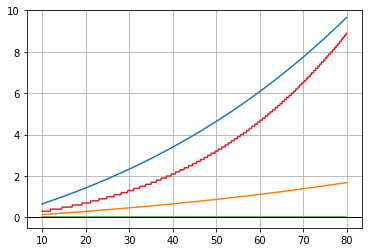

In [38]:
d = np.arange(10,80,.1)
p = 100*(prob_pneumonitis(d)[0]-prob_pneumonitis(d)[1])
p2 = 100*H_lung(d,CI='upper')
p3 = 100*H_lung(d,CI='lower')
e = 100*prob_esoph(d)
e2 = 100*H_esoph(d,CI='lower')
e3 = 100*H_esoph(d,CI='upper')
c = .074*d/14

fig,ax = plt.subplots()

ax.plot(d,p2,d,p3)
ax.plot(d,e2,d,e3)

ax.set_ylim(-.5,10)
ax.grid(True)
ax.axhline(y=0,c='k',lw=1)


0.98519892427296
0.9241615463007095
-0.5353474672908778 [0.05675477]
[-1.09999658] [[0.02597576]]


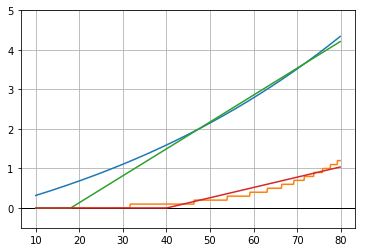

In [39]:
d = np.arange(10,80,.1)
p = 100*(prob_pneumonitis(d)[0]-prob_pneumonitis(d)[1])
e = 100*prob_esoph(d)
c = .074*d/14

fig,ax = plt.subplots()
ax.plot(d,p)
ax.plot(d,e)

ax.set_ylim(-.5,5)
ax.grid(True)
ax.axhline(y=0,c='k',lw=1)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
d=d.reshape(-1,1)
lr.fit(d,p)
print(lr.score(d,p))

d2 = np.arange(40,80,.1)
d2=d2.reshape(-1,1)
e2 = 100*prob_esoph(d2)
lr2 = LinearRegression()
lr2.fit(d2,e2)
print(lr2.score(d2,e2))

print(lr.intercept_,lr.coef_)
print(lr2.intercept_,lr2.coef_)

def risk_p(dose):
    d = np.maximum(dose-18,0)
    r = d*0.068
    return r
def risk_e(dose):
    d = np.maximum(dose-40,0)
    r = 0.026*d
    return r

ax.plot(d,risk_p(d))
ax.plot(d,risk_e(d))

In [40]:

from scipy.stats import norm

def H_esoph(dose):
    y=norm.cdf(dose/4,51,14)
    return y


def H_lung(dose_h, dose_l = 0, CI = None):
    fx_to_lung = 1/8.5
    MLDh = dose_h*fx_to_lung
    MLDl = dose_l*fx_to_lung
    b0 = -3.87
    b0u = -3.33
    b0l =  -4.49
    
    b1 = 0.126
    b1u = .153
    b1l = .100
    
    # TD50 = 30.75 [28.7–33.9] Gy
    if CI == 'upper':
        b0 = b0u
        b1 = b1u
    elif CI == 'lower':
        b0 = b0l
        b1 = b1l
    
    prob_h = np.exp(b0+b1*MLDh)/(1+np.exp(b0+b1*MLDh))
    if np.all(dose_l==0):
        prob_l = np.exp(b0+b1*MLDl)/(1+np.exp(b0+b1*MLDl))
    else:
        prob_l = np.zeros(dose_l.size)
    return prob_h - prob_l

def risk_p(dose):
    d = np.maximum(dose-18,0)
    r = d*0.068
    return r
def risk_e(dose):
    d = np.maximum(dose-40,0)
    r = 0.026*d
    return r

In [46]:
def risk_p(dose):
    r = H_lung(dose)
    return r
def risk_e(dose):
    r = H_esoph(dose)
    return r

## 60 pt group outcome analysis

In [47]:
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

### km fits

In [32]:
T = lc_df['td_yrs'].values
E = lc_df['LocalFailure'].values

idx=lc_df.gardtx>=33
T1 = T[idx]
T2 = T[~idx]
E1 = E[idx]
E2 = E[~idx]

km1 = KaplanMeierFitter()
km1.fit(T1, event_observed = E1, label = 'KM GARD>33')
km2 = KaplanMeierFitter()
km2.fit(T2, event_observed = E2, label = 'KM GARD<33')
km_all = KaplanMeierFitter()
km_all.fit(T, event_observed = E, label = 'KM All')


<lifelines.KaplanMeierFitter: fitted with 60 observations, 37 censored>

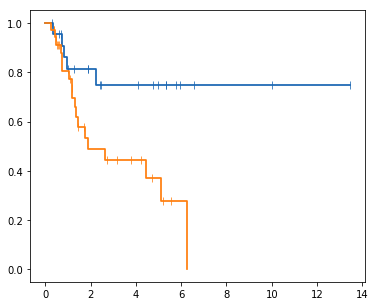

In [33]:
survtable1 = km1.survival_function_
S_km1 = survtable1.values
t_1 = survtable1.index.values

survtable2 = km2.survival_function_
S_km2 = survtable2.values
t_2 = survtable2.index.values

t1_cens = T1[np.where(E1!=1)]
C1 = survtable1.loc[t1_cens]
t2_cens = T2[np.where(E2!=1)]
C2 = survtable2.loc[t2_cens]

fig,ax = plt.subplots(figsize=(6,5))

col = (.1,.4,.7)
ax.step(t_1,S_km1,where = 'post',color=col,lw=1.75)
ax.scatter(t1_cens,C1,marker='|',color=col,s=50,lw=.75)

col  = cp[1]
ax.step(t_2,S_km2,where = 'post',color=col,lw=1.75)
ax.scatter(t2_cens,C2,marker='|',color=col,s=50,lw=.75)


In [34]:

T = lc_df['td_yrs']
E = lc_df['LocalFailure']
gard=lc_df['gardtx']
idx = gard>33

T1 = T[idx]
T2 = T[~idx]
E1 = E[idx]
E2 = E[~idx]

wf0 = WeibullFitter()
wf0.fit(T,E)
wf1 = WeibullFitter()
wf1.fit(T1, E1)
wf2 = WeibullFitter()
wf2.fit(T2, E2)

def S1(t):
    return wf1.predict(t)
def S2(t):
    return wf2.predict(t)

pd.concat([wf1.summary, wf2.summary, wf0.summary],axis=0)

,coef,se(coef),lower 0.95,upper 0.95,p,log(p)
lambda_,0.028907,0.031472,-0.032778,0.090592,3.583617e-01,-1.026213
rho_,0.641806,0.249405,0.152980,1.130631,1.007207e-02,-4.597989
lambda_,0.263115,0.054388,0.156517,0.369713,1.313162e-06,-13.543073
rho_,1.161710,0.211020,0.748119,1.575301,3.687074e-08,-17.115848
lambda_,0.138253,0.035985,0.067724,0.208782,1.220452e-04,-9.011119
rho_,0.893703,0.148328,0.602987,1.184420,1.689033e-09,-20.199110


### wbl fit for gard 33 cutpoint

In [35]:
def S1(t):
    lambda_ = 0.028907
    rho_ = 0.641806
    y = np.exp(-1*np.power(lambda_*t,rho_))
    return y

def S2(t):
    lambda_ = 0.263115
    rho_ = 1.161710
    y = np.exp(-1*np.power(lambda_*t,rho_))
    return y

## fig 3

### 0617 simulation (60 vs. 74)

In [41]:

def calc_rxdose(rsi_array):
    d = 2
    beta = 0.05
    n = 1
    alpha_array = (ln(rsi_array)+beta*n*(d**2))/(-n*d)
    rxdose_array = 33/(alpha_array+beta*d)
    return rxdose_array

def percentile(array,val):
    pp = np.argwhere(array<=val).size/array.size
    return pp

""""------------------------------------------------"""
r = nsclc.rsi

trials = 100
num_pts = 200
t=np.arange(0,10,.1)

rsi_cohort = np.zeros(num_pts)
rxdose = np.zeros(num_pts)

results_1 = np.zeros(shape=(trials,len(t)))
results_2 = np.zeros(shape=(trials,len(t)))

lc_results_1 = np.zeros(shape=(trials,len(t)))
lc_results_2 = np.zeros(shape=(trials,len(t)))

for i in range(trials):
    rsi_cohort = np.random.choice(r,num_pts)
    
    cohort_1 = calc_rxdose(np.random.choice(r,num_pts))    # 60 Gy arm
    cohort_2 = calc_rxdose(np.random.choice(r,num_pts))    # selective escalation

    """case 1: 60 vs. selected escalation to 74"""

    C1 = percentile(cohort_1,60)
    C2 = 1 - C1
    lc_cohort_1 = C1*S1(t) + C2*S2(t)

    C1 = percentile(cohort_2,74)
    C2 = 1 - C1
    lc_cohort_2 = C1*S1(t) + C2*S2(t)
    
    risk60 = (risk_p(60)+risk_e(60))/100
    plc_cohort_1 = np.power(lc_cohort_1,np.exp(risk60))

    risk74 = (risk_p(74)+risk_e(74))/100
    plc_cohort_2 = np.power(lc_cohort_2,np.exp(risk74)*(1+14/14*0.074))
    
    # append results to array
    results_1[i,:] = plc_cohort_1
    results_2[i,:] = plc_cohort_2
    
    lc_results_1[i,:] = lc_cohort_1
    lc_results_2[i,:] = lc_cohort_2

# average all plc results from trials
plc_cohort_1_ave = np.average(results_1, axis=0)
plc_cohort_2_ave = np.average(results_2, axis=0)
plc_cohort_1_std = np.std(results_1,axis=0)
plc_cohort_2_std = np.std(results_2,axis=0)

# average and std deviation for lc results all trials
lc_cohort_1_ave = np.average(lc_results_1, axis=0)
lc_cohort_2_ave = np.average(lc_results_2, axis=0)
lc_cohort_1_std = np.std(lc_results_1,axis=0)
lc_cohort_2_std = np.std(lc_results_2,axis=0)

In [42]:
time = 10
std = plc_cohort_1_std[time]
pred_1yr_efs60 = [plc_cohort_1_ave[time],plc_cohort_1_ave[time]-3*std,plc_cohort_1_ave[time]+3*std]
std = plc_cohort_2_std[time]
pred_1yr_efs74 = [plc_cohort_2_ave[time],plc_cohort_2_ave[time]-3*std, plc_cohort_2_ave[time]+3*std]

time = 20
std = plc_cohort_1_std[time]
pred_2yr_efs60 = [plc_cohort_1_ave[time],plc_cohort_1_ave[time]-3*std,plc_cohort_1_ave[time]+3*std]
std = plc_cohort_2_std[time]
pred_2yr_efs74 = [plc_cohort_2_ave[time],plc_cohort_2_ave[time]-3*std, plc_cohort_2_ave[time]+3*std]

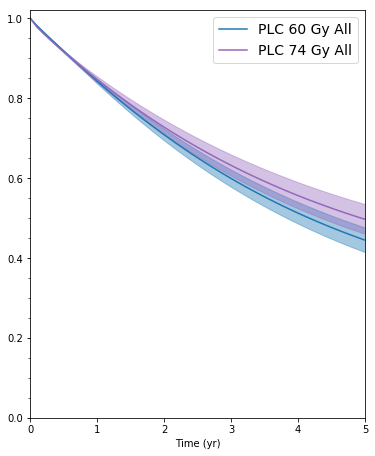

In [48]:
fig,ax = plt.subplots(figsize = (6,7.5),sharex=False)
    
"""------- first panel ---------"""

ax.plot(t,plc_cohort_1_ave, label='PLC 60 Gy All')
std = plc_cohort_1_std
ax.fill_between(t,plc_cohort_1_ave+2*std,plc_cohort_1_ave-2*std,color=cp[0],alpha=.4)

ax.plot(t,plc_cohort_2_ave, label='PLC 74 Gy All', color=cp[4])
std = plc_cohort_2_std
ax.fill_between(t,plc_cohort_2_ave+2*std,plc_cohort_2_ave-2*std,color=cp[4],alpha=.4)
  
ax.set_yticks(np.arange(0,1.2,.2),minor=False)
ax.set_xticks(range(6))
ax.set_xticklabels(list('012345'))
ax.set_xlabel('Time (yr)')
if i == 0: ax.set_ylabel('Probability of Event')
ax.set_yticks(np.arange(0,1,.05),minor=True)
ax.set_xbound(0,5)
ax.set_ylim(0,1.02)
ax.legend(fontsize=14)


Text(0.5,0,'Cohort Fraction')

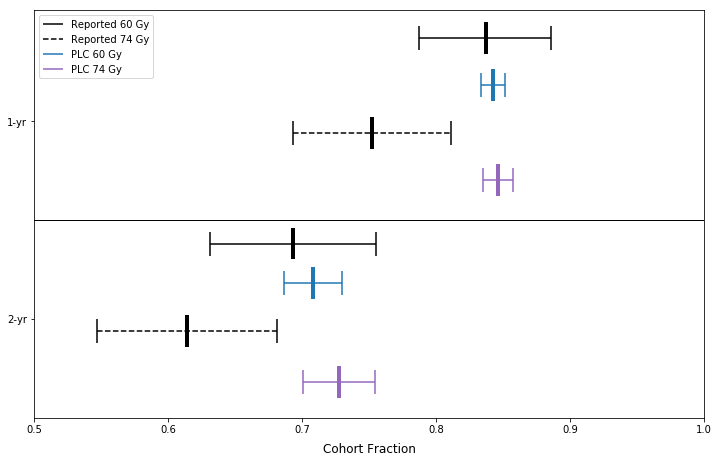

In [49]:
def boxplt(height,mean,ci_lower,ci_upper,color='k',label='',alpha=1,ls='-'):
#     ax = plt.gca()
    width = 4
    h = height
    center_xcoord = mean
    lower_xcoord = ci_lower
    upper_xcoord = ci_upper
    mid_h = .04
    end_h = .03
    kwargs = {'alpha':alpha,'color':color,'transform':ax.transData}
    ax.vlines(x=center_xcoord,ymin=h-mid_h,ymax=h+mid_h,linewidth=width,**kwargs)
    ax.vlines(x = lower_xcoord,ymin=h-end_h,ymax=h+end_h,**kwargs)
    ax.vlines(x = upper_xcoord,ymin=h-end_h,ymax=h+end_h,**kwargs)
    ax.hlines(y = h, xmin = ci_lower,xmax=ci_upper,**kwargs,linestyle=ls,label=label)

fig,ax = plt.subplots(figsize=(12,7.5))

time = 10
std = plc_cohort_1_std[time]
pred_1yr_efs60 = [plc_cohort_1_ave[time],plc_cohort_1_ave[time]-3*std,plc_cohort_1_ave[time]+3*std]

std = plc_cohort_2_std[time]
pred_1yr_efs74 = [plc_cohort_2_ave[time],plc_cohort_2_ave[time]-3*std, plc_cohort_2_ave[time]+3*std]


time = 20
std = plc_cohort_1_std[time]
pred_2yr_efs60 = [plc_cohort_1_ave[time],plc_cohort_1_ave[time]-3*std,plc_cohort_1_ave[time]+3*std]

std = plc_cohort_2_std[time]
pred_2yr_efs74 = [plc_cohort_2_ave[time],plc_cohort_2_ave[time]-3*std, plc_cohort_2_ave[time]+3*std]

reported_lc1yr_60 = [.837,.787,.886]
reported_lc1yr_74 = [.752,.693,.811]
reported_lc2yr_60 = [.693,.631,.755]
reported_lc2yr_74 = [.614,.547,.681]

h1 = [.96,.9,.84,.74,.66]
boxplt(.96,*reported_lc1yr_60,label='Reported 60 Gy')
boxplt(.72,*reported_lc1yr_74,color='k',ls='--',label='Reported 74 Gy')

boxplt(.84,*pred_1yr_efs60,color=cp[0],label = 'PLC 60 Gy')
boxplt(.6,*pred_1yr_efs74,color=cp[4],label='PLC 74 Gy')

h2=[.44,.38,.3,.22,.14,.07]


boxplt(.34,*pred_2yr_efs60,color=cp[0])
boxplt(.09,*pred_2yr_efs74,color=cp[4])

boxplt(.44,*reported_lc2yr_60)
boxplt(.22,*reported_lc2yr_74,ls='--')

ax.axhline(y=.5,color='k',lw=1)
ax.set_yticks([.25,.75])
ax.set_yticklabels(['2-yr','1-yr'])

ax.set_ylim(0,1.03)

ax.legend(loc=2)
ax.set_xlim(.5,1)

ax.set_xlabel('Cohort Fraction',labelpad=8,fontsize=12)


## fig 3 all panels

/Users/geoffreysedor/anaconda3/lib/python3.7/site-packages/matplotlib/gridspec.py:314: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



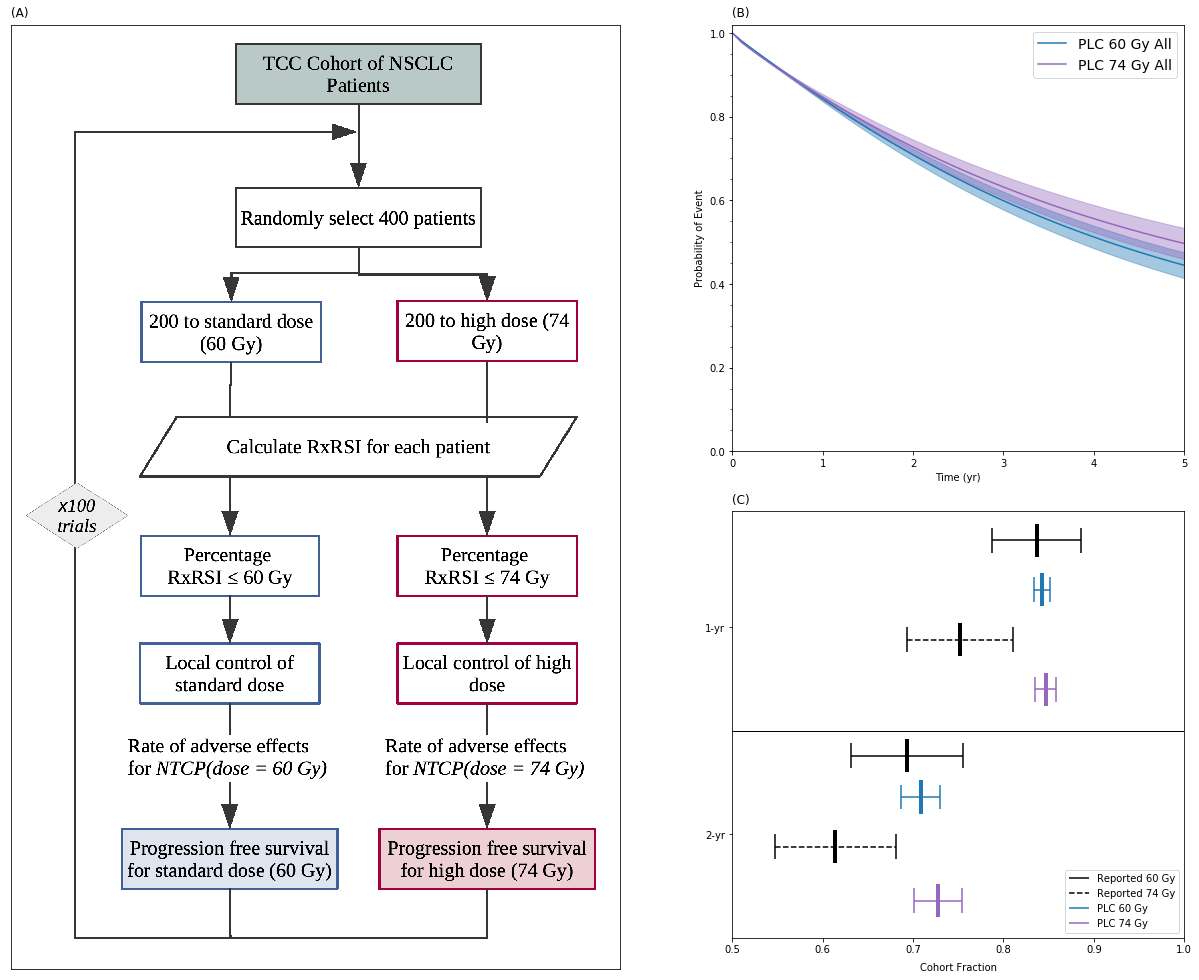

In [45]:
from matplotlib.gridspec import GridSpec

def boxplt(height,mean,ci_lower,ci_upper,color='k',label='',alpha=1,ls='-'):
#     ax = plt.gca()
    width = 4
    h = height
    center_xcoord = mean
    lower_xcoord = ci_lower
    upper_xcoord = ci_upper
    mid_h = .04
    end_h = .03
    kwargs = {'alpha':alpha,'color':color,'transform':ax.transData}
    ax.vlines(x=center_xcoord,ymin=h-mid_h,ymax=h+mid_h,linewidth=width,**kwargs)
    ax.vlines(x = lower_xcoord,ymin=h-end_h,ymax=h+end_h,**kwargs)
    ax.vlines(x = upper_xcoord,ymin=h-end_h,ymax=h+end_h,**kwargs)
    ax.hlines(y = h, xmin = ci_lower,xmax=ci_upper,**kwargs,linestyle=ls,label=label)

    
fig = plt.figure(figsize=(18,14))

gs1 = GridSpec(1, 1, figure=fig)
gs2 = GridSpec(2, 1, figure=fig)

"""----------------- left panel--------------"""
ax = fig.add_subplot(gs1[0,0])
image = plt.imread('/trial_schema.png',format='png')
ax.imshow(image)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('(A)',loc='left',pad=8)

"""-----------------bottom right panel--------------"""
ax = fig.add_subplot(gs2[1,0])

reported_lc1yr_60 = [.837,.787,.886]
reported_lc1yr_74 = [.752,.693,.811]
reported_lc2yr_60 = [.693,.631,.755]
reported_lc2yr_74 = [.614,.547,.681]

h1 = [.96,.9,.84,.74,.66]
boxplt(.96,*reported_lc1yr_60,label='Reported 60 Gy')
boxplt(.72,*reported_lc1yr_74,color='k',ls='--',label='Reported 74 Gy')
boxplt(.84,*pred_1yr_efs60,color=cp[0],label = 'PLC 60 Gy')
boxplt(.6,*pred_1yr_efs74,color=cp[4],label='PLC 74 Gy')

h2=[.44,.38,.3,.22,.14,.07]
boxplt(.34,*pred_2yr_efs60,color=cp[0])
boxplt(.09,*pred_2yr_efs74,color=cp[4])
boxplt(.44,*reported_lc2yr_60)
boxplt(.22,*reported_lc2yr_74,ls='--')

ax.axhline(y=.5,color='k',lw=1)
ax.set_yticks([.25,.75])
ax.set_yticklabels(['2-yr','1-yr'])

ax.set_ylim(0,1.03)
ax.legend(loc=4)
ax.set_xlim(.5,1)
ax.set_xlabel('Cohort Fraction',labelpad=8)
ax.set_title('(C)',loc='left',pad=8)

                        
                        
"""-----------------top right panel--------------"""
ax = fig.add_subplot(gs2[0,0])


ax.plot(t,plc_cohort_1_ave, label='PLC 60 Gy All')
std = plc_cohort_1_std
ax.fill_between(t,plc_cohort_1_ave+2*std,plc_cohort_1_ave-2*std,color=cp[0],alpha=.4)

ax.plot(t,plc_cohort_2_ave, label='PLC 74 Gy All', color=cp[4])
std = plc_cohort_2_std
ax.fill_between(t,plc_cohort_2_ave+2*std,plc_cohort_2_ave-2*std,color=cp[4],alpha=.4)
  
ax.set_yticks(np.arange(0,1.2,.2),minor=False)
ax.set_xticks(range(6))
ax.set_xticklabels(list('012345'))
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Probability of Event')
ax.set_yticks(np.arange(0,1,.05),minor=True)
ax.set_xbound(0,5)
ax.set_ylim(0,1.02)
ax.legend(fontsize=14)
ax.set_title('(B)',loc='left',pad=8)

midpoint = 0.57
gs1.tight_layout(fig, rect=[0, 0, midpoint, .98])
gs2.tight_layout(fig, rect=[midpoint,0,.97,.98])
